In [1]:
import pandas as pd
import os
from rdflib import Graph, Namespace
from collections import defaultdict
from tqdm.notebook import tqdm
import json

VIOLATION_LIST_FILE = "./json/violation_list.json" # path to store the violation list
STUDY_CSV_FILE = "./csv/study.csv" # path to store the tabluraized study csv file
STUDY_TTL_PATH = './ttl/study.ttl' # contains the actual study data
OMICS_MODEL_TTL_PATH = './ttl/omics_model.ttl' # contains the ontology
VIOLATION_REPORT_TTL_PATH = './ttl/violation_report.ttl' # contains the shacl violation test case result


In [2]:
print("Reading study graph...")
study_graph = Graph()
study_graph.parse(STUDY_TTL_PATH, format="ttl")

print("Reading violations graph...")
violations_graph = Graph()
violations_graph.parse(VIOLATION_REPORT_TTL_PATH, format="ttl")

Reading study graph...
Reading violations graph...


<Graph identifier=N8000d2695bd24762a19ee5edf5276dbc (<class 'rdflib.graph.Graph'>)>

In [3]:
from rdflib import Graph, Namespace
from rdflib.namespace import NamespaceManager
from collections import defaultdict
import json
import pandas as pd
from tqdm import tqdm

SH = Namespace("http://www.w3.org/ns/shacl#")

def count_violations(violations: Graph):
    d_focus_node_d_source_shape_counts = defaultdict(lambda: defaultdict(int))
    d_violation_focus_node = defaultdict((int))
    d_violation_source_shape = defaultdict((int))
    violation_list = []

    for s, p, o in tqdm(violations, desc="Processing Graph Once"):
        if p == SH.sourceShape:
            d_violation_source_shape[str(s)] = str(o)
            violation_list += [str(o)]
        elif p == SH.focusNode:
            d_violation_focus_node[str(s)] = str(o)

    # for key in violation_focuus_node dict
    for key in tqdm(d_violation_focus_node, desc="Going Over Violation Instances"):
        # init with 1 or add 1 if already exists
        d_focus_node_d_source_shape_counts[d_violation_focus_node[key]][d_violation_source_shape[key]] += 1

    violation_list = list(set(violation_list))
    return d_focus_node_d_source_shape_counts, violation_list


def count_violations_old(violations: Graph):
    violation_counts = defaultdict(lambda: defaultdict(int))
    current_focus_node = None
    violation_list = []

    for s, p, o in tqdm(sorted(violations, key=lambda x: str(x[0])), desc="Processing violations"):  # sorting triples based on subject
        if p == SH.focusNode:
            current_focus_node = str(o)
        elif current_focus_node and p == SH.sourceShape:
            violation_list += [str(o)]
            violation_counts[current_focus_node][str(o)] += 1

    violation_list = list(set(violation_list))

    return violation_counts, violation_list


def save_violation_list(violation_list):
    with open(VIOLATION_LIST_FILE, 'w') as f:
        json.dump(violation_list, f)  


def create_study_dataframe(study: Graph, violation_counts):
    study_df = pd.DataFrame(violation_counts).T.fillna(0)

    for s, p, o in tqdm(study, desc="Processing study"):
        if str(s) in study_df.index:
            if str(p) not in study_df.columns:
                study_df[str(p)] = ""
            study_df.at[str(s), str(p)] = str(o)

    study_df['focus_node'] = study_df.index

    return study_df


def save_study_dataframe(study_df):
    study_df.to_csv(STUDY_CSV_FILE)


def tabularize_graphs(study: Graph, violations: Graph):
    violation_counts, violation_list = count_violations(violations)
    save_violation_list(violation_list)
    study_df = create_study_dataframe(study, violation_counts)
    save_study_dataframe(study_df)


tabularize_graphs(study_graph, violations_graph)

study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)
study_df.head()


Processing study: 100%|██████████| 97794/97794 [00:01<00:00, 94602.34it/s]


,http://data.boehringer.com/ontology/omics/ece15faa-30b3-471c-ae51-2d6d1f80e3a9,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-isMeasuredOnPlatform,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-hasSequencingProtocol,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-isPreparedByLibrary,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-hasStrandedness,http://data.boehringer.com/ontology/omics/9589ebf0-6f4f-4b80-9a5a-75aa25b5715f,http://data.boehringer.com/ontology/omics/248e9792-8549-4e0d-8665-06c42aff8ffc,http://data.boehringer.com/ontology/omics/38c0a1c7-1c92-489a-a22e-87f5335ccb1a,http://data.boehringer.com/ontology/omics/0c2600b5-30b2-40c7-917a-b402e73f55ae,http://data.boehringer.com/ontology/omics/af998a22-f11b-43ea-b0ac-44e728baeafb,...,http://data.boehringer.com/ontology/omics/hasContactCompBio,http://data.boehringer.com/ontology/omics/sequencingDate,http://data.boehringer.com/ontology/omics/externalStudyId,http://data.boehringer.com/ontology/omics/hasStudyType,http://data.boehringer.com/ontology/omics/keywords,http://data.boehringer.com/ontology/omics/sourceStudyId,http://data.boehringer.com/ontology/omics/isSequencedForIndication,http://data.boehringer.com/ontology/omics/studyTitle,http://data.boehringer.com/ontology/omics/technicalStudyTitle,focus_node
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_923,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/TranscriptOmic...
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_337,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/TranscriptOmic...
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_290,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/TranscriptOmic...
http://data.boehringer.com/uuid/PrimaryCellSpecimen/bc2494df-0496-4b60-859b-db44c5fb2ad5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/PrimaryCellSpe...
http://data.boehringer.com/uuid/PrimaryCellSpecimen/fa51b445-6ff2-4936-81a1-f6b4af2cee7c,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/PrimaryCellSpe...


In [4]:
import unittest
from rdflib import Graph, Literal, Namespace, BNode, URIRef

SH = Namespace("http://www.w3.org/ns/shacl#")

class TestCountViolations(unittest.TestCase):
    def setUp(self):
        self.violations = Graph()

    def test_count_violations_node_with_multiple_and_node_with_double(self):
        self.focusNode1 = BNode()
        self.focusNode2 = BNode()
        self.sourceShape1 = Literal('shape1')
        self.sourceShape2 = Literal('shape2')
        self.violation1 = BNode()
        self.violation2 = BNode()
        self.violation3 = BNode()
        self.violation4 = BNode()

        # Add triples to the violations graph
        self.violations.add((self.violation1, SH.focusNode, self.focusNode1))
        self.violations.add((self.violation1, SH.sourceShape, self.sourceShape1))

        self.violations.add((self.violation2, SH.focusNode, self.focusNode2))
        self.violations.add((self.violation2, SH.sourceShape, self.sourceShape2))

        self.violations.add((self.violation3, SH.focusNode, self.focusNode1))
        self.violations.add((self.violation3, SH.sourceShape, self.sourceShape1))

        self.violations.add((self.violation4, SH.focusNode, self.focusNode2))
        self.violations.add((self.violation4, SH.sourceShape, self.sourceShape1))
        violation_counts, violation_list = count_violations(self.violations)
        expected_counts = {
            str(self.focusNode1): {str(self.sourceShape1): 2},
            str(self.focusNode2): {str(self.sourceShape2): 1, str(self.sourceShape1): 1}
        }
        expected_list = [str(self.sourceShape1), str(self.sourceShape2)] 
        
        self.assertEqual(violation_counts, expected_counts)
        self.assertEqual(set(violation_list), set(expected_list))  # Use set to ignore order

    def test_count_violations_basic(self):
        self.focusNode1 = BNode()
        self.focusNode2 = BNode()
        self.focusNode3 = BNode()
        self.sourceShape1 = Literal('shape1')
        self.sourceShape2 = Literal('shape2')
        self.sourceShape3 = Literal('shape3')
        self.violation1 = BNode()
        self.violation2 = BNode()
        self.violation3 = BNode()

        # Add triples to the violations graph
        self.violations.add((self.violation1, SH.focusNode, self.focusNode1))
        self.violations.add((self.violation1, SH.sourceShape, self.sourceShape1))

        self.violations.add((self.violation2, SH.focusNode, self.focusNode2))
        self.violations.add((self.violation2, SH.sourceShape, self.sourceShape2))

        self.violations.add((self.violation3, SH.focusNode, self.focusNode3))
        self.violations.add((self.violation3, SH.sourceShape, self.sourceShape3))

        violation_counts, violation_list = count_violations(self.violations)
        expected_counts = {
            str(self.focusNode1): {str(self.sourceShape1): 1},
            str(self.focusNode2): {str(self.sourceShape2): 1},
            str(self.focusNode3): {str(self.sourceShape3): 1}
        }
        expected_list = [str(self.sourceShape1), str(self.sourceShape2), str(self.sourceShape3)] 
        
        self.assertEqual(violation_counts, expected_counts)
        self.assertEqual(set(violation_list), set(expected_list))  # Use set to ignore order

suite = unittest.TestLoader().loadTestsFromTestCase(TestCountViolations)
unittest.TextTestRunner().run(suite)


Going Over Violation Instances: 100%|██████████| 4/4 [00:00<00:00, 3264.68it/s]
.
----------------------------------------------------------------------
Ran 2 tests in 0.011s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [5]:
import pandas as pd
from rdflib import Graph
from rdflib.namespace import split_uri

def namespace_in_nsm(nsm, namespace):
    """
    Checks if a given namespace is in the provided NamespaceManager.

    Parameters:
    nsm (NamespaceManager): the NamespaceManager object to check
    namespace (str): the namespace to look for in the NamespaceManager

    Returns:
    bool: True if the namespace is in the NamespaceManager, False otherwise
    """
    for prefix, ns in nsm.namespaces():
        if str(ns) == str(namespace):
            return True
    return False

def get_qname(nsm, uri):
    """
    Returns a QName for a given URI if its namespace is in the provided NamespaceManager.
    If the namespace isn't found in the NamespaceManager, it returns the original URI.

    Parameters:
    nsm (NamespaceManager): the NamespaceManager object to use
    uri (str): the URI to transform into a QName

    Returns:
    str: a QName if the namespace of the URI is in the NamespaceManager, the original URI otherwise
    """
    namespace, name = split_uri(uri)
    if namespace_in_nsm(nsm, namespace):
        try:
            prefix, _, _ = nsm.compute_qname(uri)
            return f"{prefix}:{name}"
        except Exception as e:
            return uri
    else:
        return uri

def abbreviate_using_namespaces(study_graph: Graph, violations_graph: Graph):
    """
    Replaces URIs in a DataFrame and a list of violations with QNames if their namespaces
    are found in two provided RDF graphs. Saves the updated DataFrame and the list back to disk.

    Parameters:
    study_graph (Graph): the first RDF graph to use for namespaces
    violations_graph (Graph): the second RDF graph to use for namespaces
    """

    # load violation_list
    with open(VIOLATION_LIST_FILE, 'r') as f:
        violation_list = json.load(f)

    # read study_df tabularized data
    study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)

    # Create a new graph to combine namespaces
    combined_graph = Graph()

    # Get namespaces from both graphs and bind them to the combined graph
    for prefix, ns_uri in study_graph.namespace_manager.namespaces():
        combined_graph.namespace_manager.bind(prefix, ns_uri)

    for prefix, ns_uri in violations_graph.namespace_manager.namespaces():
        combined_graph.namespace_manager.bind(prefix, ns_uri)

    # Now use the NamespaceManager of the combined graph
    nsm_combined = NamespaceManager(combined_graph)

    # Change column names
    for col in study_df.columns:
        try:
            study_df.rename(columns={col: get_qname(nsm_combined, col)}, inplace=True)
        except:
            pass

    # Change indices and cell values
    for col in study_df.columns:
        for idx in study_df.index:
            try:
                study_df.loc[idx, col] = get_qname(nsm_combined, study_df.loc[idx, col])
            except:
                pass

    # change index
    for idx in study_df.index:
        try:
            study_df.rename(index={idx: get_qname(nsm_combined, str(idx))}, inplace=True)
        except:
            pass

    # change violation_list
    for i in range(len(violation_list)):
        try:
            violation_list[i] = get_qname(nsm_combined, violation_list[i])
        except:
            pass

    # store tabular graph as csv
    study_df.to_csv(STUDY_CSV_FILE)    

    # store violation_list as json
    with open(VIOLATION_LIST_FILE, 'w') as f:
        json.dump(violation_list, f)

abbreviate_using_namespaces(study_graph, violations_graph)

In [6]:
with open(VIOLATION_LIST_FILE, 'r') as f:
    violation_list = json.load(f)

print('unique violations ('+str(len(violation_list))+'):\n')
print('\n'.join([str(v) for v in violation_list]))

unique violations (18):

omics:af998a22-f11b-43ea-b0ac-44e728baeafb
omics:38c0a1c7-1c92-489a-a22e-87f5335ccb1a
omics:OmicsStudyShape-hasContactScientist
omics:afb51f95-5b17-45a4-b62d-c58f4998f930
omics:OmicsStudyShape-hasResponsibleSite
omics:TranscriptOmicsSampleShape-isPreparedByLibrary
omics:OmicsStudyShape-hasContactCompBio
omics:OmicsStudyShape-isSequencedForIndication
omics:9589ebf0-6f4f-4b80-9a5a-75aa25b5715f
omics:TranscriptOmicsSampleShape-isMeasuredOnPlatform
omics:TranscriptOmicsSampleShape-hasSequencingProtocol
omics:OmicsStudyShape-isSequencedForTherapeuticArea
omics:248e9792-8549-4e0d-8665-06c42aff8ffc
omics:ece15faa-30b3-471c-ae51-2d6d1f80e3a9
omics:0c2600b5-30b2-40c7-917a-b402e73f55ae
omics:TranscriptOmicsSampleShape-hasStrandedness
omics:OmicsStudyShape-isPartOfProject
omics:OmicsStudyShape-hasStudyType


In [7]:
study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)
study_df.head()

,omics:ece15faa-30b3-471c-ae51-2d6d1f80e3a9,omics:TranscriptOmicsSampleShape-isMeasuredOnPlatform,omics:TranscriptOmicsSampleShape-hasSequencingProtocol,omics:TranscriptOmicsSampleShape-isPreparedByLibrary,omics:TranscriptOmicsSampleShape-hasStrandedness,omics:9589ebf0-6f4f-4b80-9a5a-75aa25b5715f,omics:248e9792-8549-4e0d-8665-06c42aff8ffc,omics:38c0a1c7-1c92-489a-a22e-87f5335ccb1a,omics:0c2600b5-30b2-40c7-917a-b402e73f55ae,omics:af998a22-f11b-43ea-b0ac-44e728baeafb,...,omics:hasContactCompBio,omics:sequencingDate,omics:externalStudyId,omics:hasStudyType,omics:keywords,omics:sourceStudyId,omics:isSequencedForIndication,omics:studyTitle,omics:technicalStudyTitle,focus_node
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_923,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/TranscriptOmic...
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_337,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/TranscriptOmic...
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_290,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/TranscriptOmic...
http://data.boehringer.com/uuid/PrimaryCellSpecimen/bc2494df-0496-4b60-859b-db44c5fb2ad5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/PrimaryCellSpe...
http://data.boehringer.com/uuid/PrimaryCellSpecimen/fa51b445-6ff2-4936-81a1-f6b4af2cee7c,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://data.boehringer.com/uuid/PrimaryCellSpe...


Creating UMAP embedding... (this may take some time)
UMAP(n_neighbors=72, random_state=0, verbose=True)
Tue Jun 27 10:55:24 2023 Construct fuzzy simplicial set
Tue Jun 27 10:55:24 2023 Finding Nearest Neighbors
Tue Jun 27 10:55:24 2023 Building RP forest with 9 trees
Tue Jun 27 10:55:24 2023 NN descent for 12 iterations
	 1  /  12
	Stopping threshold met -- exiting after 1 iterations
Tue Jun 27 10:55:36 2023 Finished Nearest Neighbor Search
Tue Jun 27 10:55:38 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Jun 27 10:56:47 2023 Finished embedding
UMAP embedding created and saved to ./csv/study.csv


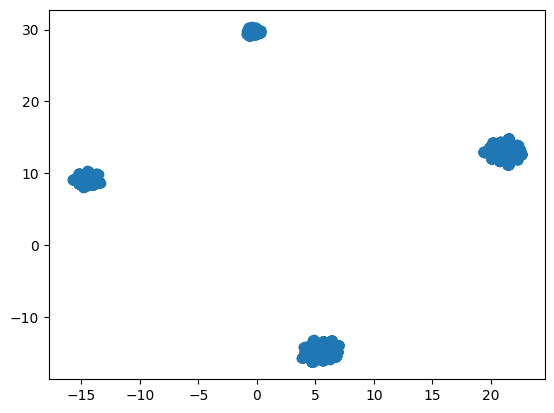

In [8]:
from matplotlib import pyplot as plt
import umap
import pandas as pd
import json
import numpy as np

def create_embedding():
    # read study.csv
    study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)
    
    # read violation_list.json
    with open(VIOLATION_LIST_FILE, 'r') as f:
        violation_columns = json.load(f)
    
    view_df = study_df[violation_columns] # view of study dataframe with only violation columns

    print("Creating UMAP embedding... (this may take some time)")
    reducer = umap.UMAP(n_neighbors=int(np.sqrt(len(view_df))), min_dist=0.1, n_components=2, random_state=0, verbose=True)
    embedding = reducer.fit_transform(view_df) # 2D projection

    study_df["x"] = embedding[:, 0]
    study_df["y"] = embedding[:, 1]

    study_df.to_csv(STUDY_CSV_FILE)
    print("UMAP embedding created and saved to", STUDY_CSV_FILE)
    

def plot_embedding():
    study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)

    plt.scatter(study_df["x"], study_df["y"])
    plt.show()

create_embedding()
plot_embedding()


In [9]:
# # TODO process ontology to differentiate between nan values: relation cannot exist given ontology, or relation is actually missing. also potentially that there is a relation when there shouldn't be but that would me more difficult to handle in the data afterwards


# from rdflib import Graph
# from rdflib.namespace import RDF, RDFS
# import networkx as nx
# import matplotlib.pyplot as plt

# # read ontology into a graph
# g_ontology = Graph()
# g_ontology.parse(OMICS_MODEL_TTL_PATH, format="ttl")

# # Assuming 'omics' is a defined prefix in the ontology
# OMICS = Namespace('http://example.org/omics#')  # replace with actual namespace URI
# subject = OMICS.PrimaryCellSpecimen

# query = """
#     SELECT ?property1 ?node1 ?property2 ?node2
#     WHERE {
#         { 
#             omics:PrimaryCellSpecimen ?property1 ?node1 .
#         } UNION {
#             omics:PrimaryCellSpecimen ?property2 ?intermediateNode .
#             ?intermediateNode ?property1 ?node2 .
#         }
#     }
# """

# # Execute the query
# # Execute the query
# results = g_ontology.query(query)

# # Create a new graph and add the results of the query
# g_results = Graph()
# for row in results:
#     if row.node2 is None:  # Direct connection
#         g_results.add((OMICS.PrimaryCellSpecimen, row.property1, row.node1))
#     else:  # Two-hop connection
#         intermediate_node = BNode()  # Create a blank node for the intermediate node
#         g_results.add((OMICS.PrimaryCellSpecimen, row.property2, intermediate_node))
#         g_results.add((intermediate_node, row.property1, row.node2))



# # Convert the RDF graph to a NetworkX graph
# G = nx.DiGraph()
# for s, p, o in g_results:
#     G.add_edge(s, o, label=p)

# # Set up the plot size
# plt.figure(figsize=(20, 20))  # Adjust as necessary

# # Set the layout and draw the graph
# pos = nx.spring_layout(G, scale=5)  # Adjust scale as necessary
# edge_labels = nx.get_edge_attributes(G, 'label')

# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)  # Adjust font size as necessary
# nx.draw_networkx_labels(G, pos, font_size=8)  # Adjust font size as necessary
# nx.draw(G, pos, node_color='y', node_size=800)

# # Show the plot
# plt.show()

In [10]:
import pandas as pd
import json
from rdflib import URIRef

# list of label predicates in ascending order of priority
label_predicates = [
    # TODO figure out whether hasValue should be used at all, or whether it should be used with hasKey+hasValue
    URIRef('http://data.boehringer.com/ontology/omics/hasValue'),
    # URIRef('http://data.boehringer.com/ontology/omics/name'),
    # URIRef('http://www.w3.org/2004/02/skos/core#prefLabel')
]

# read tabularized graph .csv as a dataframe, and violations list .json as a list
study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)

with open(VIOLATION_LIST_FILE, 'r') as f:
    violation_columns = json.load(f)

# Create a new graph to combine namespaces
combined_graph = Graph()

# Get namespaces from both graphs and bind them to the combined graph
for prefix, ns_uri in study_graph.namespace_manager.namespaces():
    combined_graph.namespace_manager.bind(prefix, ns_uri)

for prefix, ns_uri in violations_graph.namespace_manager.namespaces():
    combined_graph.namespace_manager.bind(prefix, ns_uri)

# Now use the NamespaceManager of the combined graph
nsm_combined = NamespaceManager(combined_graph)

# create a dictionary of {s: o} pairs for translating source shapes to their labels
label_dict = {}
for label_predicate in label_predicates:
    temp_dict = {str(s): str(o) for s, p, o in study_graph.triples((None, label_predicate, None))}
    # replace the temp_dict keys with their corresponding QNames
    temp_dict = {get_qname(nsm_combined, k): v for k, v in temp_dict.items()}
    # Update label_dict with temp_dict, overwriting existing keys
    label_dict.update(temp_dict)

# replace all column names, indices, and cell values in the dataframe with their corresponding labels
study_df.columns = [label_dict.get(col, col) for col in study_df.columns]
study_df.index = pd.Index([label_dict.get(idx, idx) for idx in study_df.index])
for col in study_df.columns:
    study_df[col] = study_df[col].apply(lambda x: label_dict.get(x, x))

# replace all dictionary keys and values with their corresponding labels
violation_columns = [label_dict.get(x, x) for x in violation_columns]

# store dataframe back to .csv and violations list back to .json
study_df.to_csv(STUDY_CSV_FILE)
with open(VIOLATION_LIST_FILE, 'w') as f:
    json.dump(violation_columns, f)
